In [ ]:
!pip install -q kaggle

###Subir token kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robertoandrscalfulef","key":"01e2bfb5357a163ff4efa29d0a6b4b78"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

###Descargar archivos

In [ ]:
!kaggle competitions download taller2ann-usm -f test_source_tweets.txt 
!kaggle competitions download taller2ann-usm -f train_labels.csv 
!kaggle competitions download taller2ann-usm -f train_source_tweets.txt

!kaggle datasets download -d watts2/glove6b50dtxt
!unzip glove6b50dtxt.zip

  0% 0.00/23.9k [00:00<?, ?B/s]
100% 23.9k/23.9k [00:00<00:00, 22.9MB/s]
  0% 0.00/52.3k [00:00<?, ?B/s]
100% 52.3k/52.3k [00:00<00:00, 44.1MB/s]
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 29.5MB/s]
 96% 65.0M/67.7M [00:00<00:00, 63.4MB/s]
100% 67.7M/67.7M [00:00<00:00, 125MB/s] 
Archive:  glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


###Importar librerias a utilizar

In [ ]:
import nltk
import pandas as pd
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###Cargar dataset

In [ ]:
df = pd.read_csv('train_labels.csv')
df.head()

,label,id
0,non-rumor,692735698349199360
1,unverified,525008463819464704
2,false,505611045897924608
3,non-rumor,693466724822323200
4,true,510922415468449792


In [ ]:
# --------------------------TRAIN ------------------
ftr = open("train_source_tweets.txt", "r",  encoding="ISO-8859-1")
rows = [line.split("\t",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['id','Text'])

# --------------------------TEST--------------------
ftr = open("test_source_tweets.txt", "r",  encoding="ISO-8859-1")
rows = [line.split("\t",1) for line in ftr.readlines()]
df_test = pd.DataFrame(rows, columns=['id','Text'])

df_train_text = df_train.Text
df_test_text = df_test.Text

labels_train = df.label

# Conjunto con todos los datos de entrenamiento 
df_final_text = df_train_text
labels_final = labels_train

###Crear conjunto de train  validacion

In [ ]:
from sklearn.model_selection import train_test_split
df_train_text, df_val_text, labels_train, labels_val = train_test_split(df_train_text, labels_train, test_size= 0.2, random_state=0)

###Preprocesamiento de los datos

In [ ]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    text = re.sub(r'URL','',text)
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]
texts_final = [word_extractor(text) for text in df_final_text]

print(len(texts_train))

1540


###Codificar las etiquetas

In [ ]:
from sklearn import preprocessing
from keras.utils import to_categorical
le = preprocessing.LabelEncoder()
le.fit(labels_train)

labels_train = le.transform(labels_train)
labels_train = to_categorical(labels_train)

le.fit(labels_val)

labels_val = le.transform(labels_val)
labels_val = to_categorical(labels_val)

le.fit(labels_final)
labels_final = le.transform(labels_final)
labels_final = to_categorical(labels_final)


Using TensorFlow backend.


In [ ]:
y_train = labels_train
y_val = labels_val

y_final = labels_final

###Tokernizar los conjuntos de entrenamiento, validacion y test

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train_text)

X_train = tokenizer.texts_to_sequences(df_train_text)
X_val = tokenizer.texts_to_sequences(df_val_text)
X_final = tokenizer.texts_to_sequences(df_final_text)
X_test = tokenizer.texts_to_sequences(df_test_text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(df_train_text[2])
print(X_train[2])

15 year old who "swatted" gamer convicted of domestic terrorism; 25 years to life in federal prison URL

[37, 52, 12, 498, 181, 10, 499, 195, 11, 2, 73, 6, 22, 429, 78, 1]


###Estandarizar el largo de los textos

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
x_final = pad_sequences(X_final,padding= 'post', maxlen=maxlen)
print(X_train[0, :])

[ 588 2385 2386 2387 1512   13  368  702   43 2388  262  874  703  220
    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


###Crear embedding

In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)


###Porcentaje del texto cubierto por el embedding

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

print(vocab_size)

5314


In [ ]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr[:len(arr)-1], dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>15)
        
    return embeddings_index
    
embedding = load_embed('glove.6B.50d.txt')

In [ ]:
import operator 

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = vocab[word]
            continue
        unknown_words[word] = vocab[word]

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    num_known_words = np.sum(np.asarray(list(known_words.values())))
    num_unknown_words = np.sum(np.asarray(list(unknown_words.values())))
    print('Found embeddings for  {:.3%} of all text'.format(float(num_known_words) / (num_known_words + num_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

unknown_vocab = check_coverage(tokenizer.word_index, embedding)
print("unknown vocabulary:")
print(unknown_vocab[:50])

Found embeddings for 88.253% of vocab
Found embeddings for  85.067% of all text
unknown vocabulary:
[('historyâ\x80\x94and', 5115), ('dailymirror', 5085), ('tlot', 5078), ('mmot', 5076), ('yâ\x80\x99all', 5075), ('hoverboards', 5058), ('iâ\x80\x99m', 5056), ('davidduchovny', 5055), ('gilliana', 5054), ('1dhistoryvideo', 5051), ('onedirection', 5050), ('fastâ\xa0enough', 5041), ('selfie', 5040), ('famousâ\x80\x9d', 5026), ('â\x80\x9cr', 5025), ('â\x80\x98laugh', 5014), ('girlâ\x80\x99', 5013), ('â\x80\x98sock', 5012), ('talibanswap', 5004), ('blizzard2016', 4994), ('davidsnowie', 4993), ('fergusonunity', 4989), ('24yr', 4971), ('kyliejenner', 4970), ('17yr', 4969), ('orlandoshooting', 4958), ('acarvin', 4945), ('kaitiii', 4938), ('mandaaabearr', 4937), ('weâ\x80\x99re', 4933), ('neymarjr', 4916), ('realbencarson', 4913), ('ssies', 4906), ('ð\x9f\x94¥', 4902), ('â\x80¦in', 4881), ('chewonthis', 4858), ('ð\x9f\x8e\x89ð\x9f\x94¥', 4856), ('nytopinion', 4855), ('ð\x9f\x92\x95', 4844), ('ari

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 16)       81872       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 48, 5)        245         embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 47, 5)        325         embedding_4[0][0]                
____________________________________________________________________________________________

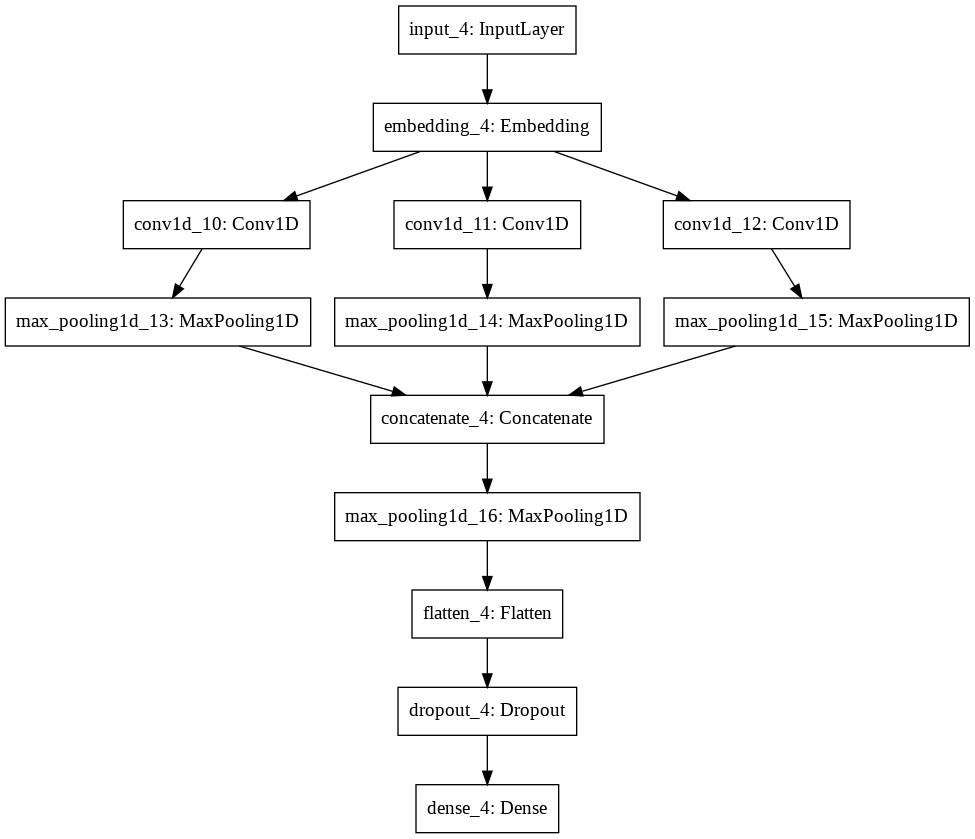

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, merge, concatenate, Input, Dropout, Embedding

# ONE LAYER
def model(output_dim=8, max_length=50, y_dim=5, num_filters=5, filter_sizes = [3,5], pooling = 'max', pool_padding = 'valid', dropout = 0.2):
    # Input Layer
#     embed_input = Input(shape=(max_length,output_dim))
    embed_input = Input(shape=(max_length,))
    x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)
#     x = SpatialDropout1D(0.2)(x)
    ## concat
    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
        if pooling=='max':
            conv = MaxPooling1D(pool_size=max_length-filter_sizes[i]+1, strides=1, padding = pool_padding)(conv)
        else:
            conv = AveragePooling1D(pool_size=max_length-filter_sizes[i]+1, strides=1, padding = pool_padding)(conv)            
        pooled_outputs.append(conv)
    merge = concatenate(pooled_outputs)
    x = MaxPooling1D(1)(merge)
    x = Flatten()(x)

    x = Dropout(dropout)(x)
#     predictions = Dense(y_dim, activation = 'sigmoid')(x)
    predictions = Dense(y_dim, activation = 'sigmoid')(x) # TEST
    
    model = Model(inputs=embed_input,outputs=predictions)

    model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
    print(model.summary())
    
    from keras.utils import plot_model
    plot_model(model, to_file='shared_input_layer.png')
    
    return model


model = model(output_dim=16, max_length=50,y_dim=4,filter_sizes = [3,4,5],pooling = 'max',dropout=0.3)
from IPython.display import Image
Image(filename='shared_input_layer.png') 

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=32)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1540 samples, validate on 386 samples
Epoch 1/30
1540/1540 [==============================] - 0s 297us/step - loss: 1.3778 - acc: 0.3052 - val_loss: 1.3764 - val_acc: 0.3653
Epoch 2/30
1540/1540 [==============================] - 0s 163us/step - loss: 1.3564 - acc: 0.4221 - val_loss: 1.3651 - val_acc: 0.4326
Epoch 3/30
1540/1540 [==============================] - 0s 163us/step - loss: 1.3270 - acc: 0.5584 - val_loss: 1.3462 - val_acc: 0.5000
Epoch 4/30
1540/1540 [==============================] - 0s 160us/step - loss: 1.2878 - acc: 0.6058 - val_loss: 1.3135 - val_acc: 0.5596
Epoch 5/30
1540/1540 [==============================] - 0s 160us/step - loss: 1.2180 - acc: 0.6753 - val_loss: 1.2574 - val_acc: 0.5855
Epoch 6/30
1540/1540 [==============================] - 0s 164us/step - loss: 1.1184 - acc: 0.6942 - val_loss: 1.1740 - val_acc: 0.5933
Epoch 7/30
1540/1540 [==============================] - 0s 169us/step - loss: 0.9818 - acc: 0.7370 - val_loss: 1.0706 - val_acc: 0.6088
E

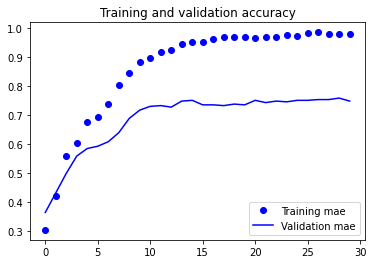

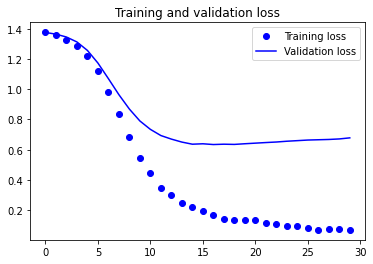

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, acc, 'bo', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
predicciones = model.predict(X_test)
# predicciones[0]
predicciones = np.argmax(predicciones, axis=1)

print(predicciones)
predicciones = le.inverse_transform(predicciones)

# predicciones.shape
# # nombres = [f'test_{i}' for i in range(1023)]
# # ids.insert(0, 'id')
# # predicciones.insert(0, 'label')
import csv

with open('test.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(predicciones, df_test.id))

[1 3 0 2 0 0 0 0 2 3 3 1 1 1 2 2 1 2 1 0 0 3 2 0 1 2 1 2 2 1 1 1 0 3 0 1 2
 2 2 2 1 3 2 1 2 3 2 0 2 2 0 0 1 0 3 2 2 0 1 2 1 0 0 1 1 2 0 2 0 2 0 0 2 2
 3 0 0 2 2 2 2 2 1 0 1 0 1 0 1 1 2 3 3 2 0 1 0 0 0 1 0 3 3 2 1 2 1 2 2 1 0
 1 1 0 2 2 0 0 1 2 1 1 1 3 0 2 3 3 0 0 0 2 2 1 2 2 0 1 0 1 2 0 2 1 2 3 2 1
 1 0 1 2 0 0 2 2 0 2 3 3 2 1 0 0 0 2 3 0 3 3 2 2 2 2 1 0 1 1 3 1 0 0 0 0 2
 2 0 3 0 0 1 1 0 2 1 0 0 3 3 1 0 0 0 1 2 2 2 0 0 1 2 1 1]
